<a href="https://colab.research.google.com/github/mrcryptsie/Emotion-Recognition-from-Speech/blob/main/detection_d'emotion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **RECONNAISSANCE DES ÉMOTIONS DANS LA PAROLE**

**Tâche:**
Construire un modèle capable de reconnaître les émotions dans l'audio de la parole. Utilisations des techniques d'apprentissage profond et de traitement de la parole pour classer les phrases parlées en différentes émotions telles que la joie, la colère ou la tristesse.

**Solution proposée:**
Nous allons affiner le modèle Hubert sur l'ensemble des données RAVDESS pour la reconnaissance des émotions dans la parole.

Nous allons suivre ces étapes dans la réalisation de notre tâche:



1.   Préparation générale
2.   Traitement des données
3.   Chargement du modèle et de l'optimiseur
4.   Entrainement
5.   Test




**1. Préparation Générale**

In [ ]:
# Importation des librairies
import time
from tqdm import tqdm

In [ ]:
import torch
cuda_id = 2
device = torch.device("cuda:%s" % cuda_id if torch.cuda.is_available() else "cpu")
device_name = torch.cuda.get_device_name(cuda_id) if torch.cuda.is_available() else "cpu"
print("Nous utilisons un  %s - %s" % (device, device_name))

Nous utilisons un  cpu - cpu


**2. Traitement des données**

Télechargeons notre datasets sur https://zenodo.org/record/1188976

In [ ]:
![ -f Audio_Speech_Actors_01-24.zip ] && echo "File existed" || wget "https://zenodo.org/record/1188976/files/Audio_Speech_Actors_01-24.zip?download=1" -O Audio_Speech_Actors_01-24.zip

--2024-01-07 07:56:36--  https://zenodo.org/record/1188976/files/Audio_Speech_Actors_01-24.zip?download=1
Resolving zenodo.org (zenodo.org)... 188.184.98.238, 188.185.79.172, 188.184.103.159, ...
Connecting to zenodo.org (zenodo.org)|188.184.98.238|:443... connected.
HTTP request sent, awaiting response... 301 MOVED PERMANENTLY
Location: /records/1188976/files/Audio_Speech_Actors_01-24.zip [following]
--2024-01-07 07:56:37--  https://zenodo.org/records/1188976/files/Audio_Speech_Actors_01-24.zip
Reusing existing connection to zenodo.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 208468073 (199M) [application/octet-stream]
Saving to: ‘Audio_Speech_Actors_01-24.zip’

Audio_Speech_Actors 100%[===================>] 198.81M  19.6MB/s    in 12s     

2024-01-07 07:56:49 (17.2 MB/s) - ‘Audio_Speech_Actors_01-24.zip’ saved [208468073/208468073]



In [ ]:
![ -f "./Audio_Speech_Actors_01-24/Actor_01/03-01-01-01-01-01-01.wav" ] && echo "File existed" || unzip Audio_Speech_Actors_01-24.zip -d "./Audio_Speech_Actors_01-24/"

Archive:  Audio_Speech_Actors_01-24.zip
   creating: ./Audio_Speech_Actors_01-24/Actor_01/
  inflating: ./Audio_Speech_Actors_01-24/Actor_01/03-01-01-01-01-01-01.wav  
  inflating: ./Audio_Speech_Actors_01-24/Actor_01/03-01-01-01-01-02-01.wav  
  inflating: ./Audio_Speech_Actors_01-24/Actor_01/03-01-01-01-02-01-01.wav  
  inflating: ./Audio_Speech_Actors_01-24/Actor_01/03-01-01-01-02-02-01.wav  
  inflating: ./Audio_Speech_Actors_01-24/Actor_01/03-01-02-01-01-01-01.wav  
  inflating: ./Audio_Speech_Actors_01-24/Actor_01/03-01-02-01-01-02-01.wav  
  inflating: ./Audio_Speech_Actors_01-24/Actor_01/03-01-02-01-02-01-01.wav  
  inflating: ./Audio_Speech_Actors_01-24/Actor_01/03-01-02-01-02-02-01.wav  
  inflating: ./Audio_Speech_Actors_01-24/Actor_01/03-01-02-02-01-01-01.wav  
  inflating: ./Audio_Speech_Actors_01-24/Actor_01/03-01-02-02-01-02-01.wav  
  inflating: ./Audio_Speech_Actors_01-24/Actor_01/03-01-02-02-02-01-01.wav  
  inflating: ./Audio_Speech_Actors_01-24/Actor_01/03-01-02-02-

In [ ]:
"""import zipfile
import os

# Spécifiez le chemin du fichier zip à dézipper
zip_path = '/content/sample_data/Audio_Speech_Actors_01-24.zip'

# Spécifiez le répertoire de destination pour extraire le contenu
extract_path = '/content/drive/MyDrive/STAGE-CODE-ALPHA'

# Ouvrez le fichier zip
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    # Extrait tout le contenu dans le répertoire spécifié
    zip_ref.extractall(extract_path)

# Affiche la liste des fichiers extraits
extracted_files = os.listdir(extract_path)
print("Fichiers extraits :", extracted_files)
"""

'import zipfile\nimport os\n\n# Spécifiez le chemin du fichier zip à dézipper\nzip_path = \'/content/sample_data/Audio_Speech_Actors_01-24.zip\'\n\n# Spécifiez le répertoire de destination pour extraire le contenu\nextract_path = \'/content/drive/MyDrive/STAGE-CODE-ALPHA\'\n\n# Ouvrez le fichier zip\nwith zipfile.ZipFile(zip_path, \'r\') as zip_ref:\n    # Extrait tout le contenu dans le répertoire spécifié\n    zip_ref.extractall(extract_path)\n\n# Affiche la liste des fichiers extraits\nextracted_files = os.listdir(extract_path)\nprint("Fichiers extraits :", extracted_files)\n'

In [ ]:
import os
import pandas as pd

RAV = "/content/drive/MyDrive/STAGE-CODE-ALPHA/Audio_Speech_Actors_01-24"
print("Chemin du répertoire:", RAV)

dir_list = os.listdir(RAV)
dir_list.sort()

emotion = []
gender = []
path = []

for i in dir_list:
    subdir_path = os.path.join(RAV, i)
    fname = os.listdir(subdir_path)

    for f in fname:
        part = f.split('-')
        emotion.append(int(part[2]))

        temp = int(part[5])
        if temp % 2 == 0:
            temp = "female"
        else:
            temp = "male"
        gender.append(temp)
        path.append(os.path.join(subdir_path, f))


RAV_df = pd.DataFrame(emotion)
RAV_df = RAV_df.replace({1:'neutral', 2:'neutral', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'})
RAV_df = pd.concat([pd.DataFrame(gender), RAV_df, pd.DataFrame(emotion)],axis=1)
RAV_df.columns = ['gender','emotion','labels']
RAV_df['source'] = 'RAVDESS'
RAV_df = pd.concat([RAV_df,pd.DataFrame(path, columns = ['path'])],axis=1)
RAV_df.emotion.value_counts()

# Vérifier s'il n'y a pas de valeurs manquantes
print("Nombre de valeurs manquantes par colonne :\n", RAV_df.isnull().sum())



# Affichage des émotions et de la fréquence
print(RAV_df['emotion'].value_counts())


Chemin du répertoire: /content/drive/MyDrive/STAGE-CODE-ALPHA/Audio_Speech_Actors_01-24
Nombre de valeurs manquantes par colonne :
 gender     0
emotion    0
labels     0
source     0
path       0
dtype: int64
neutral     288
happy       192
sad         192
angry       192
fear        192
disgust     192
surprise    192
Name: emotion, dtype: int64


In [ ]:
# Spécifier les émotions à classifier et réduire le datasets en suivant les exigences de la tâche
### Nous allons juste prendre les 3 émotions suivantes:  Happy; Sad et puis Angry
df = RAV_df[(RAV_df['emotion'] == 'happy') | (RAV_df['emotion'] == 'sad') | (RAV_df['emotion'] == 'angry')]
df.head()

,gender,emotion,labels,source,path
12,male,happy,3,RAVDESS,/content/drive/MyDrive/STAGE-CODE-ALPHA/Audio_...
13,female,happy,3,RAVDESS,/content/drive/MyDrive/STAGE-CODE-ALPHA/Audio_...
14,male,happy,3,RAVDESS,/content/drive/MyDrive/STAGE-CODE-ALPHA/Audio_...
15,female,happy,3,RAVDESS,/content/drive/MyDrive/STAGE-CODE-ALPHA/Audio_...
16,male,happy,3,RAVDESS,/content/drive/MyDrive/STAGE-CODE-ALPHA/Audio_...


In [ ]:
df['labels'].values

array([3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5,
       5, 5, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5,
       5, 5, 5, 5, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5,
       5, 5, 5, 5, 5, 5, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4,
       5, 5, 5, 5, 5, 5, 5, 5, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4,
       4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4,
       4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4,
       4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 3, 3, 3, 3, 3, 3, 3, 3,
       4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 3, 3, 3, 3, 3, 3,
       3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 3, 3, 3, 3,
       3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 3, 3,
       3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5,
       3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5,
       5, 5, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4,

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 576 entries, 12 to 1415
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   gender   576 non-null    object
 1   emotion  576 non-null    object
 2   labels   576 non-null    int64 
 3   source   576 non-null    object
 4   path     576 non-null    object
dtypes: int64(1), object(4)
memory usage: 27.0+ KB


In [ ]:
# Voir la dimensions de notre dataset
df.shape

(576, 5)

In [ ]:
# Séparer nos données en test et entrainement
train_df = df.sample(frac=0.85)
test_df = df.drop(train_df.index)

In [ ]:
print("Données d'entrainement:", train_df.shape)
print("Données de test:", test_df.shape)

Données d'entrainement: (490, 5)
Données de test: (86, 5)


In [ ]:
# Voir le nombre de valeurs  par variable de la colonne cible
train_df["emotion"].value_counts()

sad      167
angry    165
happy    158
Name: emotion, dtype: int64

In [ ]:
train_df['path']

1230    /content/drive/MyDrive/STAGE-CODE-ALPHA/Audio_...
1113    /content/drive/MyDrive/STAGE-CODE-ALPHA/Audio_...
983     /content/drive/MyDrive/STAGE-CODE-ALPHA/Audio_...
202     /content/drive/MyDrive/STAGE-CODE-ALPHA/Audio_...
275     /content/drive/MyDrive/STAGE-CODE-ALPHA/Audio_...
                              ...                        
1101    /content/drive/MyDrive/STAGE-CODE-ALPHA/Audio_...
1229    /content/drive/MyDrive/STAGE-CODE-ALPHA/Audio_...
1352    /content/drive/MyDrive/STAGE-CODE-ALPHA/Audio_...
77      /content/drive/MyDrive/STAGE-CODE-ALPHA/Audio_...
269     /content/drive/MyDrive/STAGE-CODE-ALPHA/Audio_...
Name: path, Length: 490, dtype: object

In [ ]:
# Voir la première ligne de notre datasets
import IPython.display as ipd
id = 0
#print(train_df.iloc[id])
print(train_df.iloc[id]["path"])

ipd.Audio(data=train_df.iloc[id]["path"], autoplay=True, rate=16000)

/content/drive/MyDrive/STAGE-CODE-ALPHA/Audio_Speech_Actors_01-24/Actor_21/03-01-05-01-02-01-21.wav


***Tokenization***


In [ ]:
!pip install datasets

from transformers import Wav2Vec2FeatureExtractor
from datasets import Dataset
import librosa

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.7 MB/s eta 0:00:00


In [ ]:
def map_to_array(example):
  speech, _ = librosa.load(example['path'], sr=16000, mono=True)
  example['speech'] = speech
  return example
train_data = Dataset.from_pandas(train_df).map(map_to_array)
test_data = Dataset.from_pandas(test_df).map(map_to_array)

feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained("superb/hubert-large-superb-er")

train_encoding = feature_extractor(list(train_data['speech']), sampling_rate=16000, padding=True, return_tensors="pt")
test_encoding = feature_extractor(list(test_data['speech']), sampling_rate=16000, padding=True, return_tensors="pt")


Map:   0%|          | 0/490 [00:00<?, ? examples/s]

Map:   0%|          | 0/86 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/212 [00:00<?, ?B/s]

In [ ]:
# Définir la classe du datasets
class EmotionDataset(torch.utils.data.Dataset):
  def __init__(self, encodings, labels):
    self.encodings = encodings
    pattern = {3:0, 4:1, 5:2}
    self.labels = [pattern[x] for x in labels]

  def __getitem__(self, idx):
    item = {key: val[idx] for key, val in self.encodings.items()}
    item['labels'] = torch.tensor(self.labels[idx])
    return item

  def __len__(self):
    return len(self.labels)

train_dataset = EmotionDataset(train_encoding, list(train_data['labels']))
test_dataset = EmotionDataset(test_encoding, list(test_data["labels"]))

**3. Chargement du modèle et de l'optimiseur**

In [ ]:
import torch
from transformers import HubertForSequenceClassification
from torch.optim import AdamW

# Définition du dispositif
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Chargement des modèles
model = HubertForSequenceClassification.from_pretrained("superb/hubert-large-superb-er")
model.to(device)

# Chargement de l'optimiseur
optim = AdamW(model.parameters(), lr=1e-5)


config.json:   0%|          | 0.00/1.83k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.26G [00:00<?, ?B/s]

Some weights of the model checkpoint at superb/hubert-large-superb-er were not used when initializing HubertForSequenceClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSequenceClassification were not initialized from the model checkpoint at superb/hubert-large-superb-er and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'hubert.encoder.pos_conv_embed.conv.parametri

**4. Entrainement**

In [ ]:
# Fonction de prédictions
def predict(outputs):
  probabilities = torch.softmax(outputs['logits'], dim=1)
  predictions = torch.argmax(probabilities, dim=1)
  return predictions


In [ ]:
# Entraînement du modèle

from torch.utils.data import DataLoader

# Définir le nombre d'époques
epoch = 3

# Commencer l'entraînement
model.train()

# Initialiser les listes pour stocker la perte d'entraînement et les précisions
train_loss = list()
train_accuracies = list()

# Boucle sur le nombre d'époques
for epoch_i in range(epoch):
    print('Époque %s/%s' % (epoch_i + 1, epoch))
    time.sleep(0.3)  # Ajout d'une pause pour l'affichage

    # Obtenir les données d'entraînement avec DataLoader
    train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)

    correct = 0
    count = 0
    epoch_loss = list()

    # Utiliser tqdm pour une barre de progression
    pbar = tqdm(train_loader)
    for batch in pbar:
        optim.zero_grad()

        # Charger les données du lot sur le GPU
        input_ids = batch['input_values'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # Passer les données à travers le modèle
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs['loss']
        loss.backward()
        optim.step()

        # Faire des prédictions
        predictions = predict(outputs)

        # Calculer la précision
        correct += predictions.eq(labels).sum().item()
        count += len(labels)
        accuracy = correct * 1.0 / count

        # Afficher le progrès avec les métriques
        pbar.set_postfix({
            'Perte': '{:.3f}'.format(loss.item()),
            'Précision': '{:.3f}'.format(accuracy)
        })

        # Enregistrer la perte pour chaque lot
        epoch_loss.append(loss.item())

    pbar.close()

    # Enregistrer la perte et la précision pour chaque époque
    train_loss += epoch_loss
    train_accuracies.append(accuracy)


Epoch 1/3


100%|██████████| 245/245 [1:08:23<00:00, 16.75s/it, Loss=0.484, Accuracy=0.578]


Epoch 2/3


100%|██████████| 245/245 [1:07:39<00:00, 16.57s/it, Loss=0.918, Accuracy=0.729]


Epoch 3/3


100%|██████████| 245/245 [1:07:34<00:00, 16.55s/it, Loss=0.539, Accuracy=0.747]


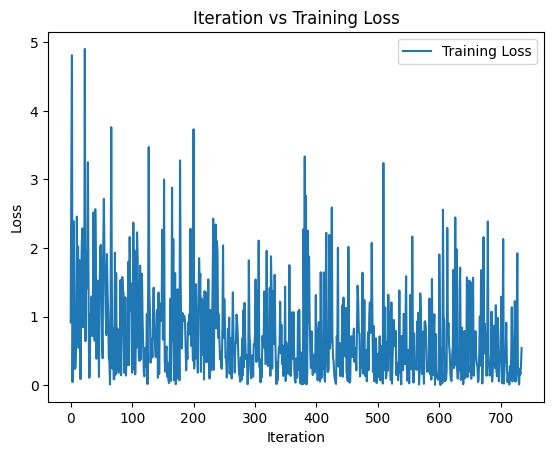

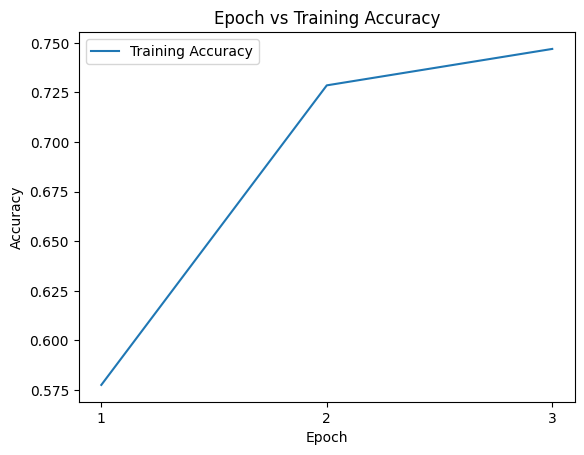

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Tracer la perte d'entraînement en fonction de l'itération
plt.plot(train_loss, label="Training Loss")
plt.xlabel("Itération")
plt.ylabel("Perte")
plt.title("Itération vs Perte d'entraînement")
plt.legend()
plt.show()

# Tracer la précision d'entraînement en fonction de l'époque
acc_X = np.arange(len(train_accuracies)) + 1
plt.plot(acc_X, train_accuracies, "-", label="Training Accuracy")
plt.xticks(acc_X)
plt.xlabel("Époque")
plt.ylabel("Précision")
plt.title("Époque vs Précision d'entraînement")
plt.legend()
plt.show()


**5. Test**

In [ ]:
# Test

from torch.utils.data import DataLoader

# Obtenir les données de test avec DataLoader
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Commencer les tests
model.eval()

# Désactiver le calcul du gradient pendant les tests
with torch.no_grad():

    correct = 0
    count = 0
    record = {"labels": list(), "predictions": list()}

    # Utiliser tqdm pour une barre de progression
    pbar = tqdm(test_loader)
    for batch in pbar:
        # Charger les données de test sur le GPU
        input_ids = batch['input_values'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs['loss']

        # Faire des prédictions
        predictions = predict(outputs)

        # Calculer la précision
        correct += predictions.eq(labels).sum().item()
        count += len(labels)
        accuracy = correct * 1.0 / count

        # Afficher le progrès avec les métriques
        pbar.set_postfix({
            'Perte': '{:.3f}'.format(loss.item()),
            'Précision': '{:.3f}'.format(accuracy)
        })

        # Enregistrer les résultats
        record["labels"] += labels.cpu().numpy().tolist()
        record["predictions"] += predictions.cpu().numpy().tolist()

    pbar.close()

# Ajouter une pause pour l'affichage
time.sleep(0.3)
print("La précision finale sur l'ensemble de test : %s%%" % round(accuracy*100, 4))


100%|██████████| 86/86 [03:23<00:00,  2.36s/it, loss=0.463, accuracy=0.779]


The final accuracy on the test dataset: 77.907%


In [ ]:
# Convertir l'enregistrement de test en un objet DataFrame de pandas
from pandas.core.frame import DataFrame
df_record = DataFrame(record)
df_record.columns = ["Vérité Terrain", "Prédiction du Modèle"]

def get_emotion(label_id):
    return model.config.id2label[label_id]

# Mapper les identifiants d'émotion aux étiquettes correspondantes
df_record["Vérité Terrain"] = df_record.apply(lambda x: get_emotion(x["Vérité Terrain"]), axis=1)
df_record["Prédiction du Modèle"] = df_record.apply(lambda x: get_emotion(x["Prédiction du Modèle"]), axis=1)

# Concaténer les textes de test et les enregistrements de test
df = pd.concat([test_df.reset_index(), df_record["Prédiction du Modèle"]], axis=1)
df["émotion"] = df.apply(lambda x: x["émotion"][:3], axis=1)

# Afficher les résultats du test
# pd.set_option('display.max_rows', None)    # Afficher toutes les lignes
# df

# Afficher les prédictions incorrectes
df[df["émotion"] != df["Prédiction du Modèle"]]


,index,gender,emotion,labels,source,path,Model Prediction
0,13,female,hap,3,RAVDESS,/content/drive/MyDrive/STAGE-CODE-ALPHA/Audio_...,neu
1,24,male,sad,4,RAVDESS,/content/drive/MyDrive/STAGE-CODE-ALPHA/Audio_...,hap
3,72,male,hap,3,RAVDESS,/content/drive/MyDrive/STAGE-CODE-ALPHA/Audio_...,neu
4,73,female,hap,3,RAVDESS,/content/drive/MyDrive/STAGE-CODE-ALPHA/Audio_...,neu
5,85,female,sad,4,RAVDESS,/content/drive/MyDrive/STAGE-CODE-ALPHA/Audio_...,hap
...,...,...,...,...,...,...,...
81,1350,male,ang,5,RAVDESS,/content/drive/MyDrive/STAGE-CODE-ALPHA/Audio_...,neu
82,1354,male,ang,5,RAVDESS,/content/drive/MyDrive/STAGE-CODE-ALPHA/Audio_...,neu
83,1398,male,hap,3,RAVDESS,/content/drive/MyDrive/STAGE-CODE-ALPHA/Audio_...,neu
84,1399,female,hap,3,RAVDESS,/content/drive/MyDrive/STAGE-CODE-ALPHA/Audio_...,neu


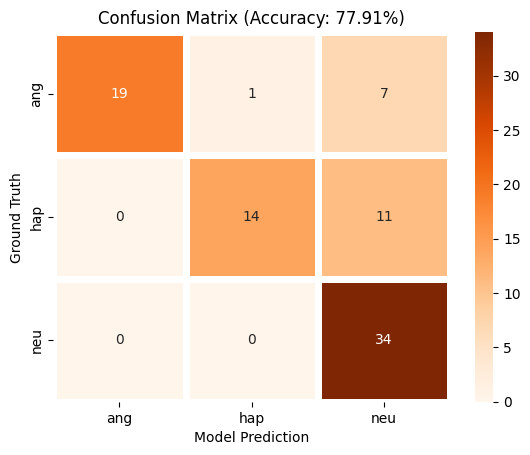

In [ ]:
# Afficher la matrice de confusion
import seaborn as sns
crosstab = pd.crosstab(df_record["Vérité Terrain"], df_record["Prédiction du Modèle"])
sns.heatmap(crosstab, cmap='Oranges', annot=True, fmt='g', linewidths=5)

# Calculer la précision à partir de la matrice de confusion
accuracy = df_record["Vérité Terrain"].eq(df_record["Prédiction du Modèle"]).sum() / len(df_record["Vérité Terrain"])

# Ajouter le titre à la figure
plt.title("Matrice de Confusion (Précision : %s%%)" % round(accuracy * 100, 2))
plt.show()
